In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import h5py

In [2]:
countries = ['AT', 'BE', 'CZ', 'DE_LU', 'FR', 'HR', 'HU', 'NL', 'PL', 'RO', 'SI', 'SK']

technologies = [
    "biomass", "brown_coal", "coal_gas", "natural_gas", "hard_coal", "oil", "hydro", 
    "nuclear", "waste", "other"
]

scenarios = [
    r'$\mathrm{IO_{L1}}$ + $\mathrm{IO_{d}}$', 
    r'$\mathrm{IO_{L1}}$', 
    r'$\mathrm{IO_{L2}}$ + $\mathrm{IO_{d}}$',
    r'$\mathrm{IO_{L2}}$', 
]

In [3]:
hf_matrix = h5py.File("./coeffs_matrix.jld", "r")
alpha = hf_matrix.get("alpha")
beta = hf_matrix.get("beta")
gamma = hf_matrix.get("gamma")

In [4]:
print(alpha)

<HDF5 dataset "alpha": shape (10, 18, 4), type "<f8">


In [5]:
df_capacities = pd.read_excel("./data/installed_capacities.xlsx")
df_fuel_prices = pd.read_excel("./data/fuel_prices.xlsx")

In [6]:
display(df_fuel_prices.iloc[4000])
df_fuel_prices.iloc[0]['gas']

Unnamed: 0    2023-02-14 16:00:00
coal                        128.0
oil                     79.240741
gas                          52.5
Name: 4000, dtype: object

268.0

In [10]:
def visualise_cost_curve(zone, tech):
    t = technologies.index(tech)
    z = countries.index(zone) + 2
    cap_max = df_capacities.iloc[technologies.index(tech)][zone]

    fuel_price = 1
    if tech == 'brown_coal' or tech == 'coal_gas' or tech == 'hard_coal':
        fuel_price = df_fuel_prices.iloc[4000]['coal']
    elif tech == 'natural_gas':
        fuel_price = df_fuel_prices.iloc[4000]['gas']
    elif tech == 'oil':
        fuel_price = df_fuel_prices.iloc[4000]['oil']
    
    def c(s, x):
        if tech == 'brown_coal' or tech == 'coal_gas' or tech == 'hard_coal':
            return df_fuel_prices.iloc[4000]['coal']/10 * (alpha[t][z][s] + beta[t][z][s] * x + gamma[t][z][s] * x**2)
        elif tech == 'natural_gas':
            return df_fuel_prices.iloc[4000]['gas']/10 * (alpha[t][z][s] + beta[t][z][s] * x + gamma[t][z][s] * x**2)
        elif tech == 'oil':
            return df_fuel_prices.iloc[4000]['oil']/10 * (alpha[t][z][s] + beta[t][z][s] * x + gamma[t][z][s] * x**2)
        else:
            return alpha[t][z][s] + (beta[t][z][s] * x + gamma[t][z][s] * x**2)

    x = np.linspace(0, cap_max, 100)

    fig, ax = plt.subplots()
    
    for s in range(4):
        ax.plot(x, c(s, x))
        
    title_text = "{0} cost curve of {1}-based electricity generation".format(zone, tech.replace("_", " "))
    if fuel_price > 1:
        title_text = "{0} cost curve of {1}-based electricity generation \n (fuel price = {2} unit)".format(zone, tech.replace("_", " "), fuel_price)
    plt.title(title_text)
    plt.ylabel('Price [€/MWh]')
    plt.xlabel('Generation output [MW]')
    plt.legend(labels=scenarios)
    plt.show()

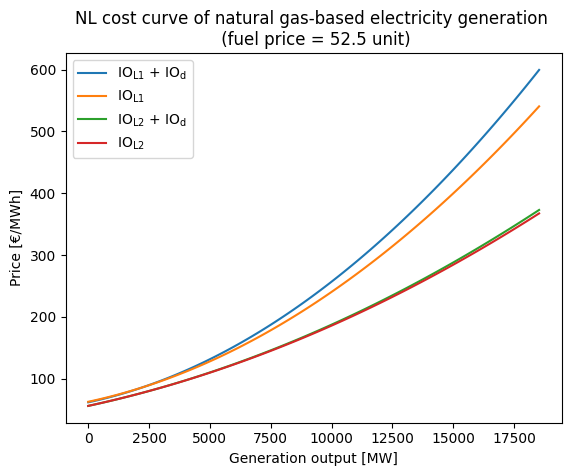

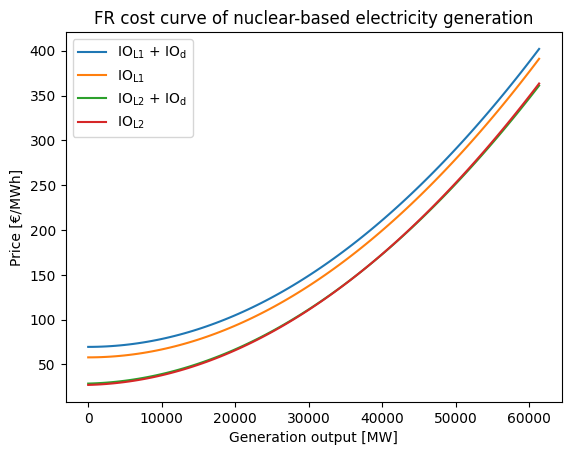

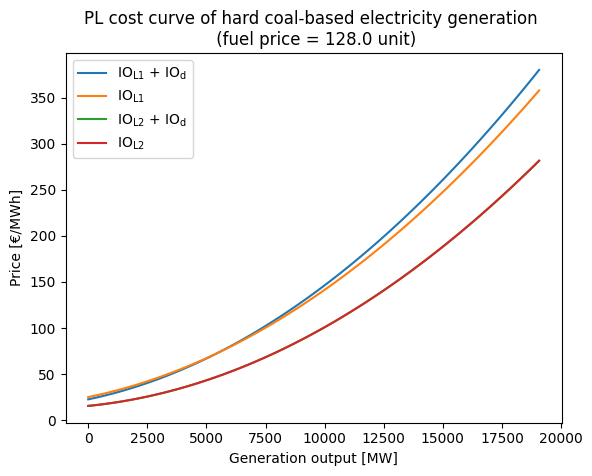

In [11]:
visualise_cost_curve('NL', 'natural_gas')
visualise_cost_curve('FR', 'nuclear')
visualise_cost_curve('PL', 'hard_coal')